# Chelsea Bridge Lift Prediction: Unified MLP Pipeline

In [ ]:
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import resample
import matplotlib.pyplot as plt


In [9]:
from google.colab import files
uploaded = files.upload()

bridge_df = pd.read_excel("Chelsea Bridge Data Points_03272025.xlsx")
weather_df = pd.read_csv("open-meteo-52.55N13.41E38m.csv")
with open("id.xml", "r") as f:
    tide_xml = "<root>" + f.read() + "</root>"


Saving open-meteo-52.52N13.42E38m.csv to open-meteo-52.52N13.42E38m.csv
Saving open-meteo-52.55N13.41E38m.xlsx to open-meteo-52.55N13.41E38m (1).xlsx
Saving open-meteo-52.55N13.41E38m.csv to open-meteo-52.55N13.41E38m (1).csv
Saving id.xml to id (1).xml
Saving Chelsea Bridge Data Points_03272025.xlsx to Chelsea Bridge Data Points_03272025 (1).xlsx


In [14]:
# Chelsea Street Bridge coordinates
latitude = 42.3917
longitude = -71.0336
start_date = "2024-05-01"
end_date = "2024-06-01"

# Fetch data
url = (
    f"https://archive-api.open-meteo.com/v1/era5?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly=temperature_2m,precipitation"
)

response = requests.get(url)
data = response.json()

# Construct DataFrame
weather_df = pd.DataFrame({
    'datetime': pd.to_datetime(data['hourly']['time']),
    'temperature_C': data['hourly']['temperature_2m'],
    'rain_mm': data['hourly']['precipitation']
})

weather_df.head()


,datetime,temperature_C,rain_mm
0,2024-05-01 00:00:00,8.6,0.0
1,2024-05-01 01:00:00,7.9,0.0
2,2024-05-01 02:00:00,8.0,0.0
3,2024-05-01 03:00:00,7.9,0.3
4,2024-05-01 04:00:00,7.6,1.4


In [15]:

root = ET.fromstring(tide_xml)
tide_data = []
for item in root.findall(".//item"):
    dt = item.find("date").text + " " + item.find("time").text
    tide_data.append({
        "datetime": pd.to_datetime(dt),
        "tide_ft": float(item.find("pred").text),
        "highlow": item.find("highlow").text
    })
tide_df = pd.DataFrame(tide_data)


In [16]:
print(weather_df.columns.tolist())


['datetime', 'temperature_C', 'rain_mm']


In [18]:
# Use directly, it's already clean
weather_clean = weather_df.copy()


## Simulate Feature-Rich Bridge Lift Dataset

In [20]:

bridge_clean = bridge_df[['Week', 'Lift Type', 'Relation']].dropna(subset=['Lift Type']).reset_index(drop=True)
np.random.seed(42)
bridge_clean['Notice_min'] = np.random.randint(30, 240, size=len(bridge_clean))
bridge_clean['Vessel_Count'] = np.random.randint(1, 4, size=len(bridge_clean))
bridge_clean['Direction'] = np.random.choice(['Upstream', 'Downstream'], size=len(bridge_clean))
bridge_clean['Is_Weekend'] = np.random.choice([0, 1], size=len(bridge_clean))
bridge_clean['Day_of_Week'] = np.random.randint(0, 7, size=len(bridge_clean))
bridge_clean['Is_Daylight'] = np.random.choice([0, 1], size=len(bridge_clean))

weather_sample = resample(weather_clean[['temperature_C', 'rain_mm']], n_samples=len(bridge_clean), random_state=42)
tide_sample = resample(tide_df[['tide_ft']], n_samples=len(bridge_clean), random_state=42)
bridge_clean['Max_Temp'] = weather_sample['temperature_C'].values
bridge_clean['Precipitation'] = weather_sample['rain_mm'].values
bridge_clean['Tide_Level'] = tide_sample['tide_ft'].values

bridge_clean['Lift_Duration'] = (
    10 + (bridge_clean['Notice_min'] < 90).astype(int) * 3
    + bridge_clean['Precipitation'] * 10
    + (bridge_clean['Tide_Level'] > 9).astype(int) * 2
    + (bridge_clean['Lift Type'] == 'Tug-Only').astype(int) * 2
    + np.random.normal(0, 3, len(bridge_clean))
).clip(5, 30)


##  Train & Evaluate MLP Model

In [21]:
features = bridge_clean[['Notice_min', 'Vessel_Count', 'Is_Weekend', 'Day_of_Week',
                         'Is_Daylight', 'Max_Temp', 'Precipitation', 'Tide_Level']]
target = bridge_clean['Lift_Duration']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

mlp_model = MLPRegressor(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
predictions = mlp_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
within_5 = (abs(y_test - predictions) <= 5).mean()

print(f" MAE: {mae:.2f} minutes")
print(f" R² Score: {r2:.2f}")
print(f" ±5 Minute Accuracy: {within_5*100:.1f}%")


 MAE: 3.19 minutes
 R² Score: 0.27
 ±5 Minute Accuracy: 80.3%


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


##  Visualize Predictions vs Actual

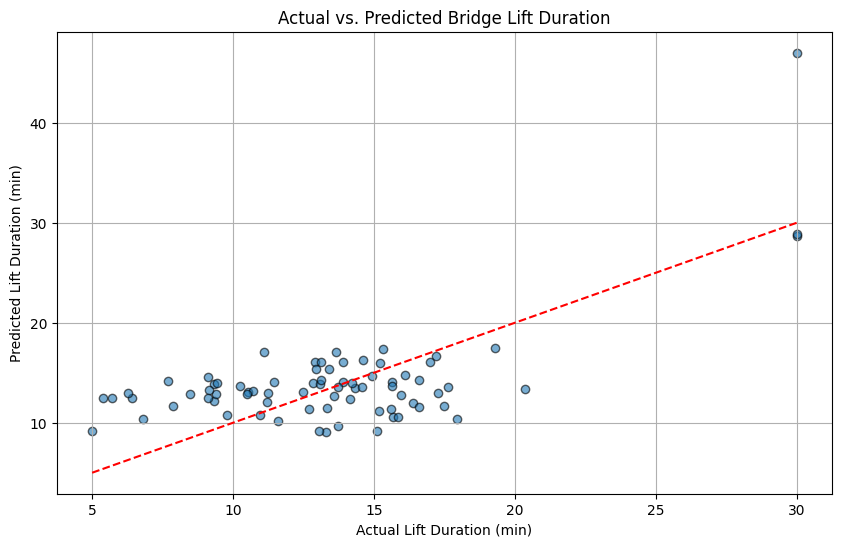

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions, alpha=0.6, edgecolor='k')
plt.xlabel("Actual Lift Duration (min)")
plt.ylabel("Predicted Lift Duration (min)")
plt.title("Actual vs. Predicted Bridge Lift Duration")
plt.plot([5, 30], [5, 30], 'r--')
plt.grid(True)
plt.show()
